In [1]:
import tensorflow as tf
import qriemannopt as qro
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

### Auxiliary functions

In [2]:
def kron(A, B):
    """
    Returns kronecker product of two square matrices.
    Args:
        A: complex valued tf tensor of shape (dim1, dim1)
        B: complex valued tf tensor of shape (dim2, dim2)
    Returns:
        complex valued tf tensor of shape (dim1 * dim2, dim1 * dim2),
        kronecker product of matrices
    """
    
    dim1 = A.shape[-1]
    dim2 = B.shape[-1]
    AB = tf.transpose(tf.tensordot(A, B, axes=0), (0, 2, 1, 3))
    return tf.reshape(AB, (dim1 * dim2, dim1 * dim2))


@tf.function
def unitary_layer(psi, U1, U2):
    """
    Returns psi vector after layer of unitary
    transformations.
    Args:
        psi: complex valued tf tensor of shape (2 ** n,),
        where n -- number of qubits
        U1: list of complex valued tf tensors of shape
        ((n - 1) / 2, 4, 4)
        U2: list of complex valued tf tensors of shape
        ((n - 1) / 2, 4, 4)
    Returns:
        complex valued tf tensor of shape (2 ** n,)
    """
    
    layer1 = tf.eye(2, dtype=tf.complex128)
    layer2 = tf.eye(2, dtype=tf.complex128)
    
    for i in range(U1.shape[0]):
        layer1 = kron(layer1, U1[i])
        
    for i in range(U2.shape[0] - 1, -1, -1):
        layer2 = kron(U2[i], layer2)
        
    return (layer2 @ (layer1 @ psi[:, tf.newaxis]))[:, 0]


def u_gen(n, dim):
    """
    Returns random unitary.
    Args:
        n: int number, number of unitary matrices
        dim: int number, dimension of unitary 
    Returns:
        complex valued tf tensor of shape (n, dim, dim)
    """
    
    U = qro.manifold.real_to_complex(tf.random.normal((n, dim,  dim, 2), dtype=tf.float64))
    U, _ = tf.linalg.qr(U)
    return U


def entropy(psi):
    """
    Returns Renyi entangled entropy between
    first left part (5 spins) anf right part
    (6 spins).
    Args:
        psi: complex valued tf.tensor of shape (2 ** 11,),
        psi vector
    Returns:
        tf scalar, Renyi entropy
    """
    
    rho = tf.tensordot(psi, tf.math.conj(psi), axes=0)
    rho = tf.reshape(rho, (2 ** 5, 2 ** 6, 2 ** 5, 2 ** 6))
    rho = tf.transpose(rho, (0, 2, 1, 3))
    rho = tf.linalg.trace(rho)
    return -tf.math.log(tf.linalg.trace(rho @ rho))

### Number of layers, initial unitary matrices and initial state of chain

In [3]:
num_of_layers = 3 # number of unitary layers

# initial unitary matrices
U1 = [qro.manifold.complex_to_real(u_gen(5, 4)) for i in range(num_of_layers)]
U2 = [qro.manifold.complex_to_real(u_gen(5, 4)) for i in range(num_of_layers)]

# initial state
psi = np.zeros((2 ** 11, 2), dtype=np.float64)
psi[0, 0] = 1
psi = qro.manifold.real_to_complex(tf.constant(psi))

### Optimization loop

In [6]:
# parameters
#===========#
iters = 1000
lr = 0.1
#===========#

# optimizer
m = qro.manifold.StiefelManifold()
opt = qro.optimizers.RAdam(m, lr, ams=True)

# variables
varU1 = list(map(tf.Variable, U1))
varU2 = list(map(tf.Variable, U2))

# exact value of maximal entropy
exact_S = np.log(2 ** 5)

err_list = [] # will be filled by err vs iter

# optimization loop
for i in tqdm(range(iters)):
    
    with tf.GradientTape() as tape:
        
        new_psi = psi
        
        varU1_c = list(map(qro.manifold.real_to_complex, varU1))
        varU2_c = list(map(qro.manifold.real_to_complex, varU2))
        
        for i in range(num_of_layers):
            
            new_psi = unitary_layer(new_psi, varU1_c[i], varU2_c[i])
        
        loss = tf.cast(-entropy(new_psi), dtype=tf.float64)
        err_list.append(exact_S + loss)
        
    
    grad = tape.gradient(loss, varU1 + varU2)
    opt.apply_gradients(zip(grad, varU1 + varU2))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.09it/s]


### Plotting

Exact entropy: 3.4657359027997265
Obtained entropy: 3.4657355656877344


Text(0.5, 0, 'iter')

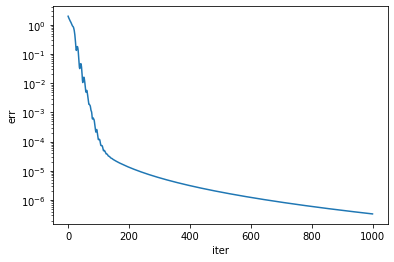

In [9]:
print("Exact entropy:", exact_S)
print("Obtained entropy:", -loss.numpy())
plt.plot(err_list)
plt.yscale('log')
plt.ylabel('err')
plt.xlabel('iter')